In [17]:
# Task 1: minimal tokenizer sanity checks (run in a notebook cell)

from tokenizers import Tokenizer

TOKENIZER_PATH = "c:\\1_Shre_Core\\Professional\\Upskilling\\AIML\\nano-moe\\tokenizer.json"       # adjust if needed
TEXT_PATH = "c:\\1_Shre_Core\\Professional\\Upskilling\\AIML\\nano-moe\\data\\tokenizer.txt"      # adjust if needed

tok = Tokenizer.from_file(TOKENIZER_PATH)

special = ["[UNK]", "[PAD]", "[BOS]", "[EOS]"]
ids = {s: tok.token_to_id(s) for s in special}
print("special_token_ids:", ids)

special_token_ids: {'[UNK]': 0, '[PAD]': 1, '[BOS]': 2, '[EOS]': 3}


In [ ]:
min(list(tok.get_vocab().values()))

0

In [34]:
tok.decode(tok.encode("HI, I am Shreyash").ids)

'HI, I am Shreyash'

In [35]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

In [65]:
max_tk = []
for i in range(20000):
    max_tk.append(len(tok.encode(ds['train']['text'][i]).ids))

s = 0
for _ in max_tk:
    if _ >500: s+=1

s*100/len(max_tk)

3.415

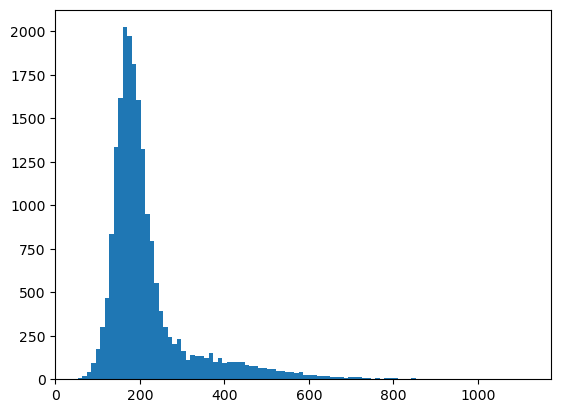

In [66]:
import matplotlib.pyplot as plt
plt.hist(max_tk, bins=100);

In [67]:
import json
from pathlib import Path

import numpy as np
from tokenizers import Tokenizer


In [70]:
# Paths
shard_dir = Path("c:\\1_Shre_Core\\Professional\\Upskilling\\AIML\\nano-moe\\data\\shards")
meta_path = shard_dir / "meta.json"
tokenizer_path = Path("c:\\1_Shre_Core\\Professional\\Upskilling\\AIML\\nano-moe\\tokenizer.json")

assert meta_path.exists(), f"Missing: {meta_path}"
assert tokenizer_path.exists(), f"Missing: {tokenizer_path}"


In [71]:
# Load metadata + tokenizer
meta = json.loads(meta_path.read_text(encoding="utf-8"))
tok = Tokenizer.from_file(str(tokenizer_path))

vocab_size = int(meta["vocab_size"])
dtype = meta["dtype"]
max_seq_len = int(meta["max_seq_len"])

ids = meta["special_token_ids"]
unk_id = int(ids["[UNK]"])
pad_id = int(ids["[PAD]"])
bos_id = int(ids["[BOS]"])
eos_id = int(ids["[EOS]"])

assert dtype == "uint16", f"Expected uint16, got {dtype}"
assert 0 <= bos_id < vocab_size and 0 <= eos_id < vocab_size


In [72]:
def check_bin(split_name: str, preview_tokens: int = 200, head_tokens: int = 1000, sample_checks: int = 50):
    bin_name = meta["files"][split_name]
    bin_path = shard_dir / bin_name
    assert bin_path.exists(), f"Missing: {bin_path}"

    mm = np.memmap(bin_path, dtype=np.uint16, mode="r")
    n = mm.shape[0]
    assert n > 0, f"{split_name} is empty"

    head = np.array(mm[: min(head_tokens, n)], dtype=np.uint16)
    min_id = int(head.min())
    max_id = int(head.max())

    assert min_id >= 0, f"{split_name}: min token id {min_id} < 0"
    assert max_id < vocab_size, f"{split_name}: max token id {max_id} >= vocab_size {vocab_size}"
    assert int(head[0]) == bos_id, f"{split_name}: first token {int(head[0])} != BOS {bos_id}"

    preview = np.array(mm[: min(preview_tokens, n)], dtype=np.uint16).astype(np.int32).tolist()
    decoded = tok.decode(preview)

    # Random window checks for next-token alignment
    L = max_seq_len + 1  # 513
    assert n >= L, f"{split_name}: not enough tokens for one window (need {L}, have {n})"

    rng = np.random.default_rng(123)
    for _ in range(sample_checks):
        s = int(rng.integers(0, n - L + 1))
        chunk = np.array(mm[s : s + L], dtype=np.uint16).astype(np.int32)
        x = chunk[:-1]
        y = chunk[1:]
        assert np.array_equal(y[:-1], x[1:]), f"{split_name}: shift check failed at start={s}"

    print(f"[{split_name}] file={bin_name}")
    print(f"  tokens={n}")
    print(f"  head_min_id={min_id}  head_max_id={max_id}")
    print(f"  first_20_ids={head[:20].astype(np.int32).tolist()}")
    print("  decoded_preview=")
    print(decoded[:500])


check_bin("train")
check_bin("val")


[train] file=train.bin
  tokens=55463679
  head_min_id=2  head_max_id=7896
  first_20_ids=[2, 426, 441, 262, 394, 15, 397, 284, 262, 392, 443, 496, 374, 17, 317, 503, 271, 365, 345, 2852]
  decoded_preview=
Once upon a time, there was a little girl named Lily. She loved to play with clay and make different shapes. One day, she made a good-looking horse with the clay. She was very happy and showed it to her mother.

Her mother said, "Wow, Lily! That's a beautiful horse. Can you kneel down and show me how it runs?"

Lily knelt down and made the horse run with her hands. Her mother smiled and said, "You're so creative, Lily. Keep making more things with clay." 

Lily smiled and said, "I will, Mommy. A
[val] file=val.bin
  tokens=2221647
  head_min_id=2  head_max_id=9633
  first_20_ids=[2, 1960, 269, 525, 534, 271, 365, 318, 266, 568, 17, 339, 485, 262, 408, 1825, 269, 262, 770, 4701]
  decoded_preview=
Lila and Tom like to play in the park. They have a big bucket and a small shovel. They 

In [84]:
batch

[memmap([ 512,  509,  269,  416,  262, 1039,   17,  305, 1039,  326,   15,
          329,   44, 4238, 1241,  354, 1072,  349, 1792,  345,  266, 1110,
           17, 2208,  354,  372,  648, 3149, 1277,  305,  835,  492,  269,
          754,  266, 1039,  542,  350,  266, 1110,   17,  305, 1039, 1218,
          562,  345,  262, 1040,   17,  202,  202,  378,  835,  284, 1238,
          361,  281, 7317,  269,  670,  262,  527,   17,  319,  284, 1238,
          361,  281, 3286,  575, 2999,  271,  411,   17,  891,  584,  352,
           15,  281,  630,  271,  655,  691,  262,  527,  269,  333,  841,
          271,  266, 3613,   17,    3,    2,  426,  397,  284,  262, 3746,
          496, 1247,   17,  319,  364, 1100, 1651,  318,  266, 1805, 1828,
          372,  822, 1263,  269,  281, 1217,  503,  353, 1606,   17,  202,
          202,  419,  357,   15, 1247,  364,  262, 8228,   17,  868, 1226,
          284,  971,  269,  281,  284,  396, 2884,  271,  606,  262,  711,
          304,   17,  573